In [1]:
from kan import KAN

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import *

# <center>Pré-processamento dos dados</center>

In [2]:
train_path = 'dataset_teste2/train'
test_path = 'dataset_teste2/test'

In [3]:
transform_train = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.RandomRotation(degrees=15),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

transform_test = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
train_dataset = datasets.ImageFolder(train_path, transform = transform_train)
test_dataset = datasets.ImageFolder(test_path, transform = transform_test)

In [5]:
trainloader = DataLoader(train_dataset, batch_size = 28, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 30, shuffle = True)

In [6]:
train_data = []
train_targets = []

for batch_data_train, batch_targets_train in trainloader:
    train_data.append(batch_data_train)
    train_targets.append(batch_targets_train)

train_data = torch.cat(train_data, dim=0)
train_targets = torch.cat(train_targets, dim=0)

In [8]:
test_data = []
test_targets = []

for batch_data_test, batch_targets_test in testloader:
    test_data.append(batch_data_test)
    test_targets.append(batch_targets_test)

test_data = torch.cat(test_data, dim=0)
test_targets = torch.cat(test_targets, dim=0)

In [10]:
dataset = {}

dataset['train_input'] = train_data.view(-1, 164*164*3)
dataset['test_input'] = test_data.view(-1, 164*164*3)
dataset['train_label'] = train_targets
dataset['test_label'] = test_targets

# <center>Implementação da arquitetura KAN</center>

In [11]:
model = KAN(width=[dataset['train_input'].shape[1], 14, 3], grid=3, k=3, base_fun=torch.nn.ReLU(), auto_save=False)

In [12]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))


In [13]:
results = model.fit(dataset, opt="Adam", steps=300, metrics=(train_acc, test_acc), 
                    loss_fn=torch.nn.CrossEntropyLoss(), lr=0.001, batch=30)

| train_loss: 1.30e-01 | test_loss: 8.28e-01 | reg: 2.61e+03 | : 100%|█| 300/300 [6:01:43<00:00, 72.


In [15]:
print("Acurácia dos dados de treino: ", results['train_acc'][-1])
print("Acurácia dos dados de teste: ", results['test_acc'][-1])

Acurácia dos dados de treino:  0.9900000095367432
Acurácia dos dados de teste:  0.699999988079071


Text(0.5, 0.98, 'Treinamento')

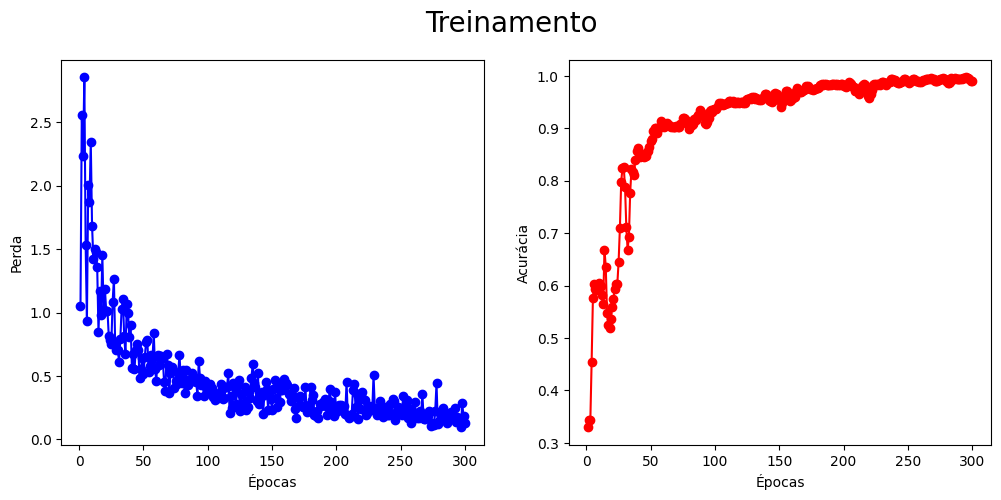

In [17]:
epochs = range(1, 301)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['train_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['train_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

Text(0.5, 0.98, 'Teste')

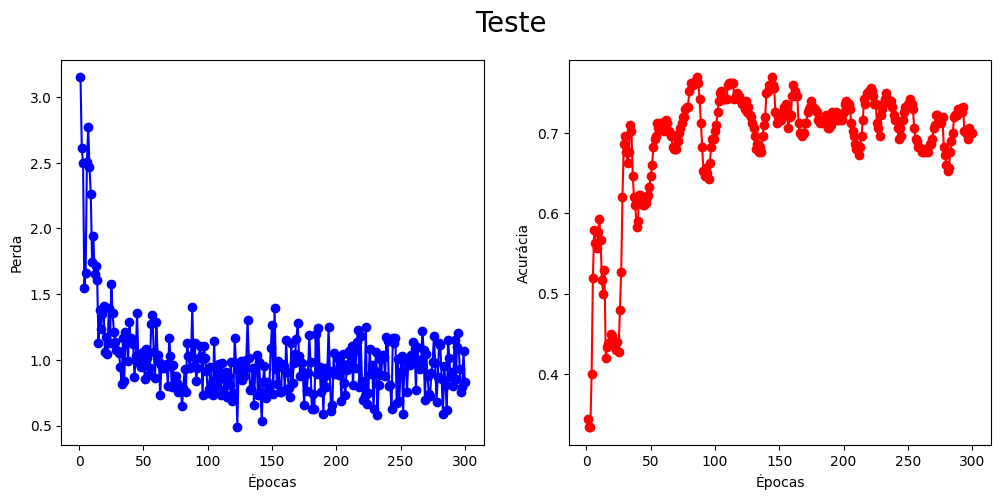

In [18]:
epochs = range(1, 301)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['test_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['test_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Teste", fontsize = 20)

In [19]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in testloader:
        images = images.view(-1, 164*164*3)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())

print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

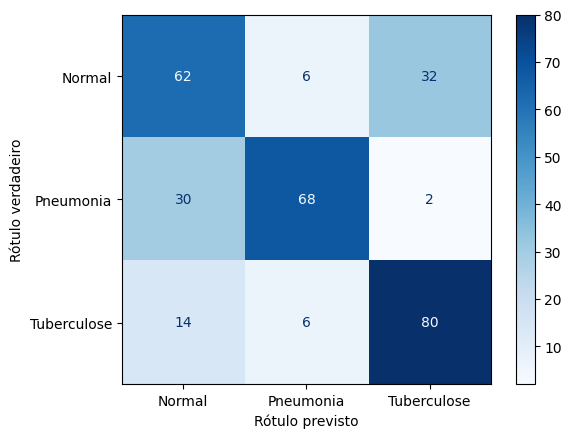

In [21]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [22]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 70.00%


In [23]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 71.22%


In [24]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 70.00%


In [25]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 70.17%


# Observações

- Modificações realizadas: Banco de dados de 1000 imagens, Valores de batch size e maneira que foi realizada os teste;
- Tempo total de treinamento: 6:01:43.